#Download and prepare Dataset

In [ ]:
!pip install opendatasets
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies/")

Skipping, found downloaded files in "./satellite-images-of-water-bodies" (use force=True to force download)


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!gdown https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n6qj1de2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-n6qj1de2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=148e8fce9ee89c8a2592edadc1c34498c0b82d99ca10b422924632890b4fe0ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-ddi6c1yx/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
To: /content/sam_vit_b.pth
100% 375M/375M [00:01<00:00, 251MB/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from PIL import Image
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
import torchvision.transforms as trans
from tqdm import tqdm

from segment_anything import SamPredictor, sam_model_registry
from transformers import SamModel, SamProcessor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Util functions

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, masks_folder, transform=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.transform = transform

        self.image_files = sorted(os.listdir(images_folder))
        self.mask_files = sorted(os.listdir(masks_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.mask_files[idx])

        image = cv2.imread(image_path)
        # print("img:",image)
        mask = cv2.imread(mask_path)
        points=extract_random_points(mask[:,:,0])

        sample = {'image': image, 'mask': mask,'landmarks':points}

        if self.transform:
            sample = self.transform(**sample)
        trans=transforms.ToTensor()
        sample['image']=trans(sample['image'])
        sample['mask']=trans(sample['mask'])
        # print(sample['image'].shape)
        return sample

def load_images_and_masks(images_folder, masks_folder,index=0):
    image_files = sorted(os.listdir(images_folder))
    mask_files = sorted(os.listdir(masks_folder))


    images = [cv2.imread(os.path.join(images_folder, image_files[index])) ]
    masks = [cv2.imread(os.path.join(masks_folder, mask_files[index])) ]
    print(f'image shape is :{images[0].shape}')
    return images, masks

def display_images_with_masks(images, masks):
    num_samples=len(images)

    for i in range(num_samples):

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title('Image')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(masks[i], cv2.COLOR_BGR2RGB))
        plt.title('Segmentation Mask')

        plt.show()

def display_samples(dataset, num_samples=3):
    to_pil = ToPILImage()

    for i in range(num_samples):
        sample = dataset[i]
        image = sample['image']
        mask = sample['mask']
        # print(f'Image type:{type(image)}')
        # Convert PyTorch tensors to PIL images
        image_pil = to_pil(image)
        mask_pil = to_pil(mask)

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image_pil)
        if i==0:
          plt.title('Original Image')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask_pil)
        if i==0:
          plt.title('Original Mask')

    plt.show()


def extract_random_points(mask, num_points=1):
    # Find the non-zero coordinates in the binary mask
    non_zero_coords = np.column_stack(np.where(mask > 250))

    # print('non zero coords',non_zero_coords.shape,mask)
    # Ensure that there are enough non-zero coordinates
    if len(non_zero_coords) < num_points:
        raise ValueError("Not enough non-zero coordinates in the mask.")

    # Randomly select num_points coordinates
    selected_coords = non_zero_coords[np.random.choice(len(non_zero_coords), num_points, replace=False)]
    # print(f'selected_coords shape: {selected_coords.shape}')
    return selected_coords


def dice_coefficient(predicted, target):
    intersection = torch.sum(predicted * target) * 2.0
    union = torch.sum(predicted) + torch.sum(target)

    dice = intersection / (union + 1e-8)
    return dice

def intersection_over_union(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection

    iou = intersection / (union + 1e-8)
    return iou


# load SAM model

In [ ]:

sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)        # pretrained sam model
processor = SamProcessor.from_pretrained("facebook/sam-vit-base") # transform images

# sam_model = sam_model_registry['vit_b'](checkpoint='sam_vit_b.pth').to(device)

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_points = [[[450, 600]]] # 2D localization of a window


In [ ]:
print(sam_model)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
#test image
# inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# outputs = sam_model(**inputs)
# pred_masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
# scores = outputs.iou_scores
# print(f"image embedding shape{pred_masks[0].shape}, scores: {scores},inputs:{inputs}")


image embedding shapetorch.Size([1, 3, 1764, 2646]), scores: tensor([[[0.9057, 0.9562, 0.9669]]], device='cuda:0', grad_fn=<SliceBackward0>),inputs:{'pixel_values': tensor([[[[-0.5082, -0.4739, -0.4054,  ..., -0.4054, -0.4054, -0.4054],
          [-1.6727, -1.7069, -1.4158,  ..., -1.4843, -1.4843, -1.5014],
          [-1.2445, -1.3473, -0.5424,  ..., -0.7479, -0.7479, -0.7993],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.3901, -0.3550, -0.2850,  ..., -0.2850, -0.2850, -0.2850],
          [-1.5805, -1.5980, -1.2829,  ..., -1.6681, -1.6681, -1.6856],
          [-1.1429, -1.2479, -0.3550,  ..., -1.4580, -1.4580, -1.4755],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [

## Freeze layers

In [ ]:
freeze_layer='mask_decoder'
for name,module in sam_model.named_children():
    if name!=freeze_layer:
      print("\n**********************\nWeights freezed for module: ",name)
      for param in module.parameters():
        param.requires_grad = False




**********************
Weights freezed for module:  shared_image_embedding

**********************
Weights freezed for module:  vision_encoder

**********************
Weights freezed for module:  prompt_encoder


## Show sample image

image shape is :(2009, 2007, 3)


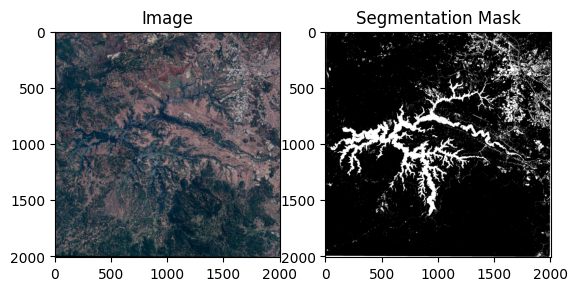

In [ ]:
images_path= '/content/satellite-images-of-water-bodies/Water Bodies Dataset/Images'
masks_path='/content/satellite-images-of-water-bodies/Water Bodies Dataset/Masks'
sample_img,sample_mas=load_images_and_masks(images_path,masks_path,0)
# print(sample_mas)

display_images_with_masks(sample_img,sample_mas)

## Augmentations

Flip dataset


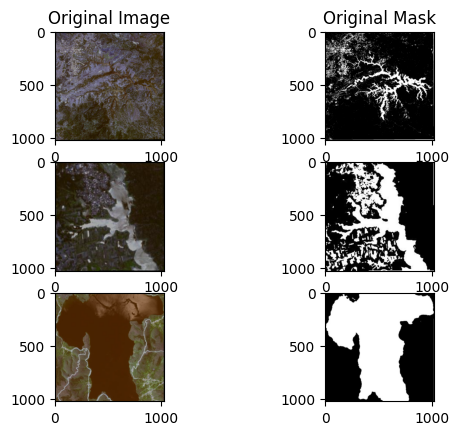

Brightness contrast dataset


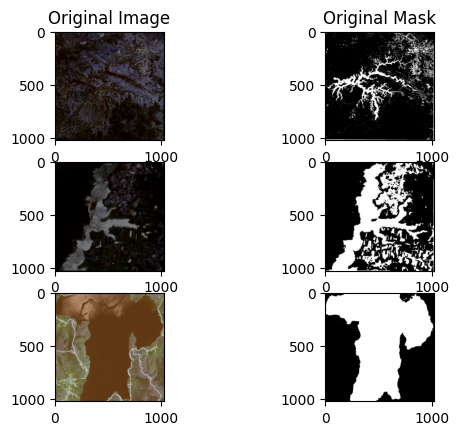

Colot jitter dataset


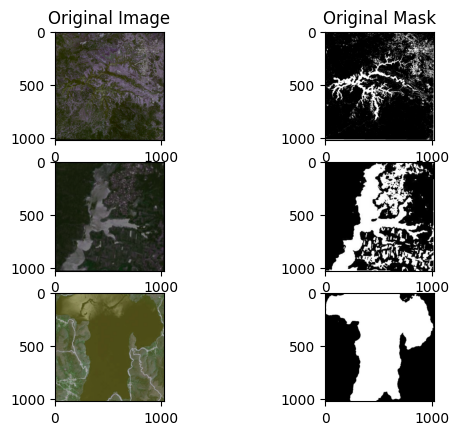

Normal dataset


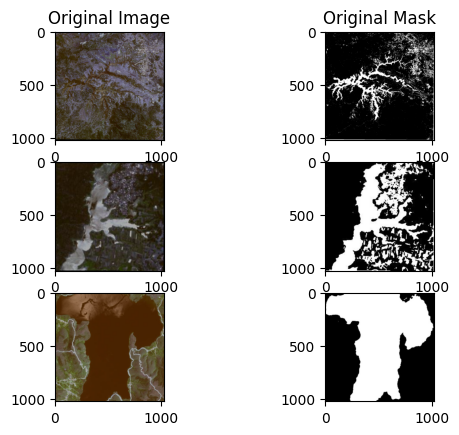

In [ ]:
input_size=(1024,1024)
flip_transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.Resize(*input_size),
])

brightness_contrast_transform = A.Compose([
    A.RandomBrightnessContrast(p=1),
    A.Resize(*input_size),

])

color_jitter_transform = A.Compose([
    A.ColorJitter(p=1),
    A.Resize(*input_size),
])

general_transform = A.Compose([
    A.Resize(*input_size),
    ])

flip_dataset = CustomDataset(images_path, masks_path, transform=flip_transform)
brightness_contrast_dataset = CustomDataset(images_path, masks_path, transform=brightness_contrast_transform)
color_jitter_dataset = CustomDataset(images_path, masks_path, transform=color_jitter_transform)
general_dataset = CustomDataset(images_path, masks_path, transform=general_transform)

print(f'Flip dataset')
display_samples(flip_dataset)
print(f'Brightness contrast dataset')
display_samples(brightness_contrast_dataset)
print(f'Colot jitter dataset')
display_samples(color_jitter_dataset)
print(f'Normal dataset')
display_samples(general_dataset)





In [ ]:
composed_dataset = ConcatDataset([flip_dataset, brightness_contrast_dataset, color_jitter_dataset,general_dataset])

torch.manual_seed(42)
# Define the percentage of data to use for validation
validation_split = 0.2
dataset_size = len(composed_dataset)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Divide the dataset into training and validation sets
train_dataset, val_dataset = random_split(composed_dataset, [train_size, validation_size])

# Create DataLoaders for the training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=3, shuffle=False)


## Fine-tune the model


In [ ]:
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(),lr=0.0001)

# Set up loss function
loss_fn = torch.nn.MSELoss()


In [ ]:
num_epochs=3
iou_list=[]
dice_list=[]
train_loss_list=[]
val_loss_list=[]
for epoch in range(num_epochs):  # num_epochs to be defined
    train_loss=0.0
    val_loss=0.
    iter=0
    for sample in tqdm(train_dataloader):
        # print(sample)
        # sample = dataset[i]
        input_image = sample['image']
        mask = sample['mask']
        points= sample['landmarks']
        gt_binary_mask = mask[:,0:1,:,:]//129
        gt_binary_mask =  gt_binary_mask.to(device)
        # print('\ninput image shape',input_image.shape,"\n*************************\n ", gt_binary_mask.shape
        #       ,'\n*********box:',points.shape)

        inputs = processor(input_image, input_points=points, return_tensors="pt").to(device)
        # print('process input_points',inputs)
        outputs = sam_model(input_points=inputs['input_points'],pixel_values=inputs['pixel_values'],multimask_output=False)
        # print('\n******\nmodel,',outputs.pred_masks.shape)
        # pred_masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
        # print('\n******\npreds:\n,',(pred_masks[0].shape),gt_binary_mask.shape)

        # Resize the tensor using bilinear interpolation
        target_size = (256, 256)
        resized_mask = F.interpolate(gt_binary_mask, size=target_size, mode='bilinear', align_corners=False).unsqueeze(dim=1)
        # Calculate loss and backpropagate
        loss = loss_fn(outputs.pred_masks.to(device), resized_mask)
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        dice_s=dice_coefficient( resized_mask,outputs.pred_masks)
        iou_s=intersection_over_union(resized_mask,outputs.pred_masks)
        train_loss_list.append(loss)
        iou_list.append(iou_list)
        dice_list.append(dice_s)
        # print('loss',loss)

        iter+=1

    print(f"epoch finished the the loss is {train_loss/iter}")



 26%|██▌       | 778/3031 [26:50<1:15:35,  2.01s/it]